In [1]:
from torch.nn import functional as F
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch import optim
from torchvision import models
from torchvision import datasets
from torchvision import transforms as T

import numpy as np
import torchutils as tu
import matplotlib.pyplot as plt

import mlflow
from mlflow.models import infer_signature
from PIL import Image

In [2]:
torch.cuda.empty_cache()

In [3]:

use_mlflow = True
mlflow_experiment_name = 'INTEL-CNN-Experiment'

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu' 
config = {
    'device': DEVICE,
    'batch_size': 1024,
    'learning_rate': 0.003,
    'epochs': 5,
    'data_dir': '../data/',
    'log_dir': './runs/eperiment2',
    'transformations': [
        'resize', 'normalize'
    ]
}

DEVICE

'cuda'

In [4]:
train_transforms = T.Compose(
    [
        T.Resize(256),                
        T.RandomResizedCrop(224, scale=(0.8, 1.0)),  
        T.RandomRotation(15),         
        T.RandomHorizontalFlip(p=0.5),
        T.ColorJitter(
            brightness=0.1,    
            contrast=0.1,      
        ),
        T.ToTensor(),
        T.Normalize(
            (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
        )
    ]
)
valid_transforms = T.Compose(
    [
        T.Resize(256),
        T.CenterCrop(224),
        T.ToTensor(),
        T.Normalize(
            (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
        )
    ]
)

In [5]:
train_dataset = datasets.ImageFolder(
    config['data_dir']+ 'seg_train/seg_train',
    transform=train_transforms
    )

valid_dataset = datasets.ImageFolder(
    config['data_dir']+ 'seg_test/seg_test',
    transform=valid_transforms
    )

In [6]:
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=config['batch_size'], shuffle=False)

In [7]:
labels = {
    0: 'buildings',
    1: 'forest',
    2: 'glacier',
    3: 'mountain',
    4: 'sea',
    5: 'street'
}

decode = lambda x: labels[x]
decode(4)

'sea'

In [8]:
model = models.resnet50(pretrained=True)

/home/o13g/bootcamp/nn_project/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/o13g/bootcamp/nn_project/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
for param in model.parameters():
    param.requires_grad = False
       
model.fc = nn.Linear(2048, 6)
model.fc.weight.requires_grad = True
model.fc.bias.requires_grad = True

model.to(DEVICE)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [10]:
optimizer = torch.optim.Adam(model.parameters(), config['learning_rate'], weight_decay=1e-5)


criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

In [11]:
tu.get_model_summary(model, torch.randn(config['batch_size'], 3, 224, 224, device=DEVICE))

Layer                                         Kernel                Output           Params               FLOPs
0_conv1                                      [3, 64, 7, 7]   [1024, 64, 112, 112]       9,408   120,846,286,848
1_bn1                                                 [64]   [1024, 64, 112, 112]         128     3,288,334,336
2_relu                                                   -   [1024, 64, 112, 112]           0                 0
3_maxpool                                                -     [1024, 64, 56, 56]           0                 0
4_layer1.0.Conv2d_conv1                     [64, 64, 1, 1]     [1024, 64, 56, 56]       4,096    13,153,337,344
5_layer1.0.BatchNorm2d_bn1                            [64]     [1024, 64, 56, 56]         128       822,083,584
6_layer1.0.ReLU_relu                                     -     [1024, 64, 56, 56]           0                 0
7_layer1.0.Conv2d_conv2                     [64, 64, 3, 3]     [1024, 64, 56, 56]      36,864   118,380,

[Epoch 00] Train loss: 1.5727, valid loss = 0.9587 Train acc 0.4792 Valid acc 0.7057
[Epoch 01] Train loss: 0.8853, valid loss = 0.7490 Train acc 0.7821 Valid acc 0.8608
[Epoch 02] Train loss: 0.7634, valid loss = 0.7274 Train acc 0.8584 Valid acc 0.8786
[Epoch 03] Train loss: 0.7285, valid loss = 0.7114 Train acc 0.8755 Valid acc 0.8825
[Epoch 04] Train loss: 0.7078, valid loss = 0.7026 Train acc 0.8861 Valid acc 0.8906


Text(0.5, 1.0, 'Acc history')

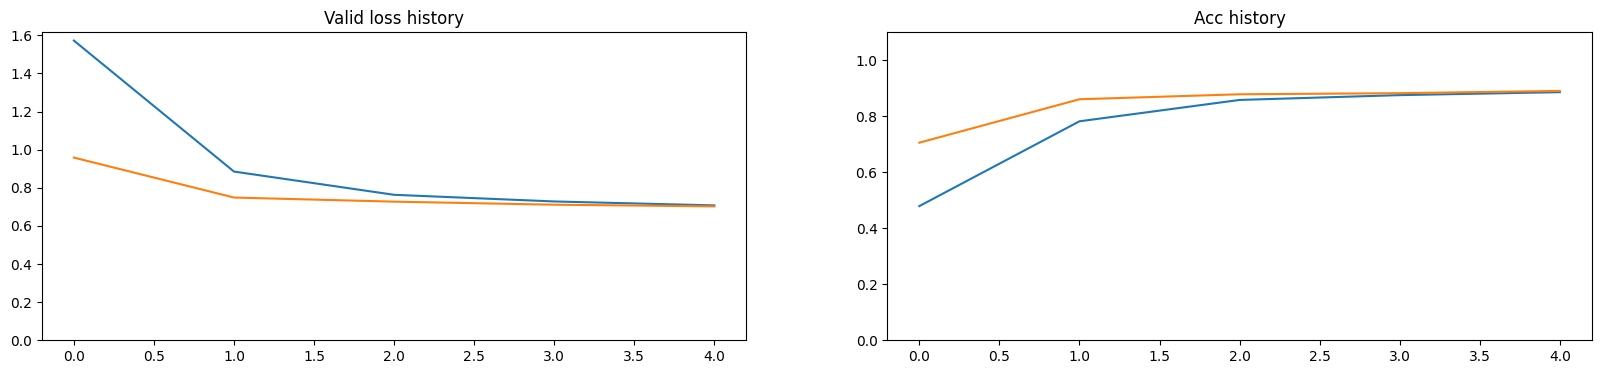

In [12]:
train_epoch_acc = []
train_epoch_losses = []
valid_epoch_losses = []
valid_epoch_acc = []

for epoch in range(config['epochs']):
    model.train()
    batch_loss = []
    batch_acc = []
    
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_loss.append(loss.item())
        _, preds = torch.max(outputs, 1)
        acc = (preds == labels).sum().item() / labels.size(0)
        batch_acc.append(acc)
        
    train_epoch_acc.append(np.mean(batch_acc))
    train_epoch_losses.append(np.mean(batch_loss))
    
    
    model.eval()
    batch_loss = []
    batch_acc = []
    
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            batch_loss.append(loss.item())
            _, preds = torch.max(outputs, 1)
            acc = (preds == labels).sum().item() / labels.size(0)
            batch_acc.append(acc)
            
    valid_epoch_losses.append(np.mean(batch_loss))
    valid_epoch_acc.append(np.mean(batch_acc))
    print(f'[Epoch {epoch:02d}] Train loss: {train_epoch_losses[-1]:.4f}, valid loss = {valid_epoch_losses[-1]:.4f} Train acc {train_epoch_acc[-1]:.4f} Valid acc {valid_epoch_acc[-1]:.4f}')
    
fig, ax = plt.subplots(1, 2, figsize=(20, 4))
ax[0].plot(train_epoch_losses)
ax[0].plot(valid_epoch_losses)
ax[0].set_ylim((0, np.max(train_epoch_losses.extend(valid_epoch_losses))))
ax[0].set_title('Valid loss history')

ax[1].plot(train_epoch_acc)
ax[1].plot(valid_epoch_acc)
ax[1].set_ylim(0, 1.1)
ax[1].set_title('Acc history')

In [13]:
img, true_label = next(iter(valid_loader))

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

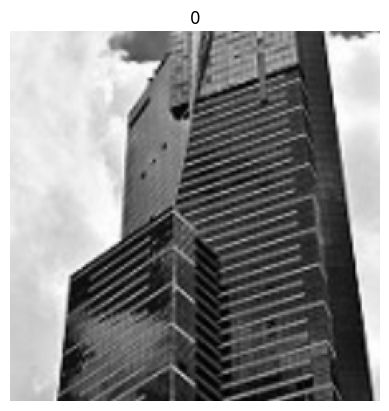

In [14]:
plt.imshow(img[0][0], cmap='gray')
plt.title(f'{true_label[0]}'); plt.axis('off')

In [15]:
img[0].unsqueeze(0).shape

torch.Size([1, 3, 224, 224])

In [16]:
with torch.inference_mode():
    pred_class = model(img[0].unsqueeze(0).to(DEVICE)).softmax(dim=1).argmax().item()

print(f'pred class: {pred_class}')

pred class: 0


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

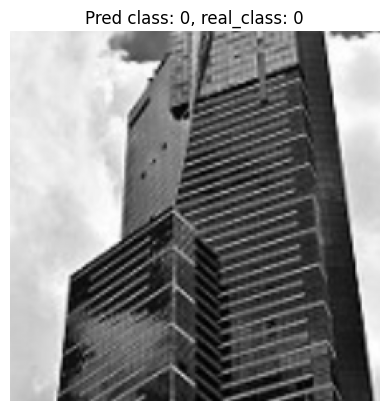

In [17]:
plt.imshow(img[0][0], cmap='gray')
plt.title(f'Pred class: {pred_class}, real_class: {true_label[0]}')
plt.axis('off')

In [18]:
#torch.save(model.state_dict(), 'model1.pt')